# Gaze Project

By - Yung-Chi Kung (yk7298)*

#### Imports

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import os
import csv
import re
import random
import matplotlib.pyplot as plt

#### Initialize model

In [31]:
mp_face_mesh = mp.solutions.face_mesh # initialize the face mesh model


In [2]:
rootdir = 'C:/Users/ykung/Downloads/facecamera'


#### Gaze detection on images

In [32]:
relative = lambda landmark, shape: (int(landmark.x * shape[1]), int(landmark.y * shape[0]))
relativeT = lambda landmark, shape: (int(landmark.x * shape[1]), int(landmark.y * shape[0]), 0)

In [33]:
def gaze(frame, points):
    """
    The gaze function gets an image and face landmarks from mediapipe framework.
    The function draws the gaze direction into the frame.
    """

    '''
    2D image points.
    relative takes mediapipe points that is normalized to [-1, 1] and returns image points
    at (x,y) format
    '''
    image_points = np.array([
        relative(points.landmark[4], frame.shape),  # Nose tip
        relative(points.landmark[152], frame.shape),  # Chin
        relative(points.landmark[263], frame.shape),  # Left eye left corner
        relative(points.landmark[33], frame.shape),  # Right eye right corner
        relative(points.landmark[287], frame.shape),  # Left Mouth corner
        relative(points.landmark[57], frame.shape)  # Right mouth corner
    ], dtype="double")

    '''
    2D image points.
    relativeT takes mediapipe points that is normalized to [-1, 1] and returns image points
    at (x,y,0) format
    '''
    image_points1 = np.array([
        relativeT(points.landmark[4], frame.shape),  # Nose tip
        relativeT(points.landmark[152], frame.shape),  # Chin
        relativeT(points.landmark[263], frame.shape),  # Left eye, left corner
        relativeT(points.landmark[33], frame.shape),  # Right eye, right corner
        relativeT(points.landmark[287], frame.shape),  # Left Mouth corner
        relativeT(points.landmark[57], frame.shape)  # Right mouth corner
    ], dtype="double")

    # 3D model points.
    model_points = np.array([
        (0.0, 0.0, 0.0),  # Nose tip
        (0, -63.6, -12.5),  # Chin
        (-43.3, 32.7, -26),  # Left eye, left corner
        (43.3, 32.7, -26),  # Right eye, right corner
        (-28.9, -28.9, -24.1),  # Left Mouth corner
        (28.9, -28.9, -24.1)  # Right mouth corner
    ])

    '''
    3D model eye points
    The center of the eye ball
    '''
    Eye_ball_center_right = np.array([[-29.05], [32.7], [-39.5]])
    Eye_ball_center_left = np.array([[29.05], [32.7], [-39.5]])  # the center of the left eyeball as a vector.

    '''
    camera matrix estimation
    '''
    focal_length = frame.shape[1]
    center = (frame.shape[1] / 2, frame.shape[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix,
                                                                  dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    # 2d pupil location
    left_pupil = relative(points.landmark[468], frame.shape)
    right_pupil = relative(points.landmark[473], frame.shape)

    # Transformation between image point to world point
    _, transformation, _ = cv2.estimateAffine3D(image_points1, model_points)  # image to world transformation

    if transformation is not None:  # if estimateAffine3D secsseded
        # project pupil image point into 3d world point
        pupil_world_cord = transformation @ np.array([[left_pupil[0], left_pupil[1], 0, 1]]).T

        # 3D gaze point (10 is arbitrary value denoting gaze distance)
        S = Eye_ball_center_left + (pupil_world_cord - Eye_ball_center_left) * 10

        # Project a 3D gaze direction onto the image plane.
        (eye_pupil2D, _) = cv2.projectPoints((int(S[0]), int(S[1]), int(S[2])), rotation_vector,
                                             translation_vector, camera_matrix, dist_coeffs)
        # project 3D head pose into the image plane
        (head_pose, _) = cv2.projectPoints((int(pupil_world_cord[0]), int(pupil_world_cord[1]), int(40)),
                                           rotation_vector,
                                           translation_vector, camera_matrix, dist_coeffs)
        # correct gaze for head rotation
        gaze = left_pupil + (eye_pupil2D[0][0] - left_pupil) - (head_pose[0][0] - left_pupil)

        # Draw gaze line into screen
        # p1 = (int(left_pupil[0]), int(left_pupil[1]))
        # p2 = (int(gaze[0]), int(gaze[1]))
        # cv2.line(frame, p1, p2, (0, 0, 255), 2)
        
        # Return gaze direction
        return gaze[0], gaze[1], head_pose[0][0]
        

In [34]:
rcheck = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if '.avi' in file:
            #print(os.path.join(subdir))
            print(os.path.join(subdir, file))
            cap = cv2.VideoCapture(os.path.join(subdir, file))
            vidlength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            gazelist = [None]*vidlength
            framenum = 0
            
            with mp_face_mesh.FaceMesh(
                    max_num_faces=1,                            # number of faces to track in each frame
                    refine_landmarks=True,                      # includes iris landmarks in the face mesh model
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5) as face_mesh:
                while cap.isOpened():
                    success, image = cap.read()
                    if not success:                            # no frame input
                        gazelist[framenum] = (0,0)
                        print("Ignoring empty camera frame.")
                        continue
                    # To improve performance, optionally mark the image as not writeable to
                    # pass by reference.
                    image.flags.writeable = False
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # frame to RGB for the face-mesh model
                    results = face_mesh.process(image)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                    if results.multi_face_landmarks:
                        gazelist[framenum] = gaze(image, results.multi_face_landmarks[0])
                        
                    framenum += 1
                    if framenum == vidlength:
                        break

                cap.release()
             
            with open(os.path.join(subdir, 'headpose.csv'), 'w', newline='') as file2:
                writer = csv.writer(file2)
                writer.writerow(gazelist)

C:/Users/ykung/Downloads/facecamera\end_action\20141019_091035_1106_1256\video_20141019_091035_1106_1256.avi


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            

<function matplotlib.pyplot.show(close=None, block=None)>

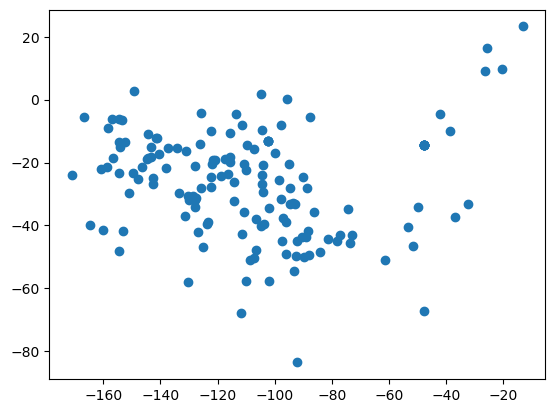

In [43]:
with open('C:/Users/ykung/Downloads/facecamera/end_action/20141019_091035_1106_1256/gazedata.csv') as file2:
    reader = csv.reader(file2, delimiter = ',')
    
    for row3 in reader:
        xvals = [None]*len(row3)
        yvals = [None]*len(row3)
        for i in range(len(row3)):
            val1 = row3[i]
            try:
                xval1 = re.search('\((.+?),', val1).group(1)
            except AttributeError:
                pass
            xvals[i] = float(xval1)
            
            try:
                yval1 = re.search(',(.+?)\)', val1).group(1)
            except AttributeError:
                pass
            yvals[i] = float(yval1)
            
plt.scatter(xvals,yvals)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

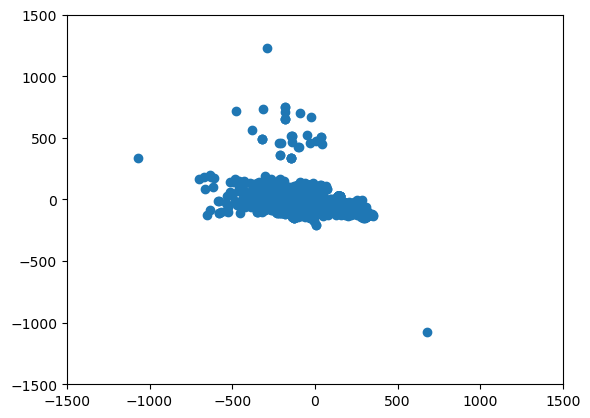

In [6]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/end_action'
completex = []
completey = []
xval1=0
yval1=0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    xvals = [None]*len(row3)
                    yvals = [None]*len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval1 = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        xvals[i] = float(xval1)

                        try:
                            yval1 = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        yvals[i] = float(yval1)
                        
                    completex = completex + xvals
                    completey = completey + yvals
                
plt.scatter(completex,completey)
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

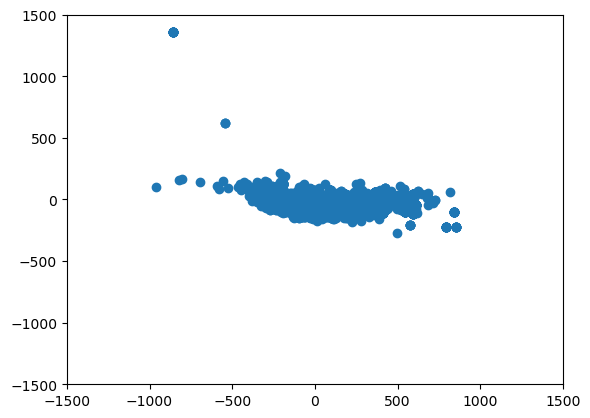

In [7]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/lchange'
completex = []
completey = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    xvals = [None]*len(row3)
                    yvals = [None]*len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval1 = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        xvals[i] = float(xval1)

                        try:
                            yval1 = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        yvals[i] = float(yval1)
                        
                    completex = completex + xvals
                    completey = completey + yvals
                
plt.scatter(completex,completey)
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

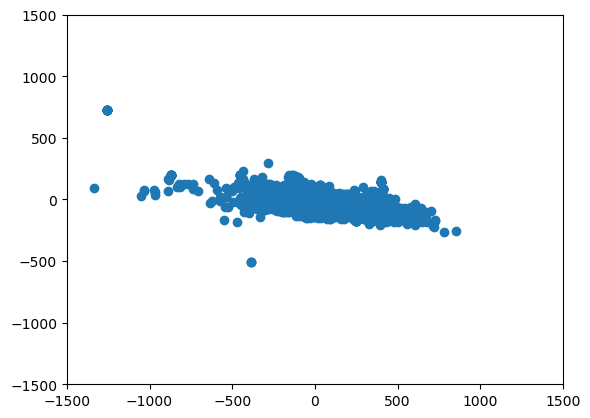

In [63]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/lturn'
completex = []
completey = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    xvals = [None]*len(row3)
                    yvals = [None]*len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval1 = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        xvals[i] = float(xval1)

                        try:
                            yval1 = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        yvals[i] = float(yval1)
                        
                completex = completex + xvals
                completey = completey + yvals
                
plt.scatter(completex,completey)
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

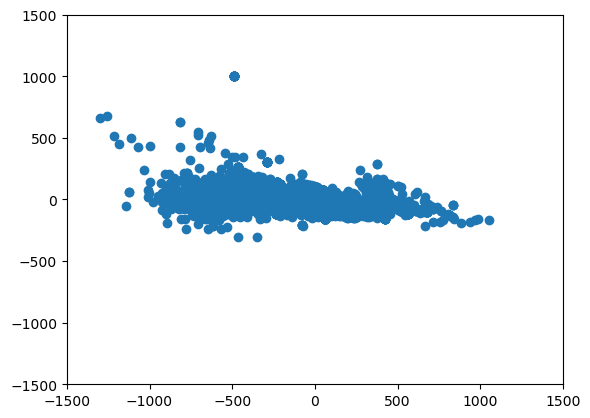

In [8]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/rturn'
completex = []
completey = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    xvals = [None]*len(row3)
                    yvals = [None]*len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval1 = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        xvals[i] = float(xval1)

                        try:
                            yval1 = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        yvals[i] = float(yval1)
                        
                    completex = completex + xvals
                    completey = completey + yvals
                
plt.scatter(completex,completey)
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

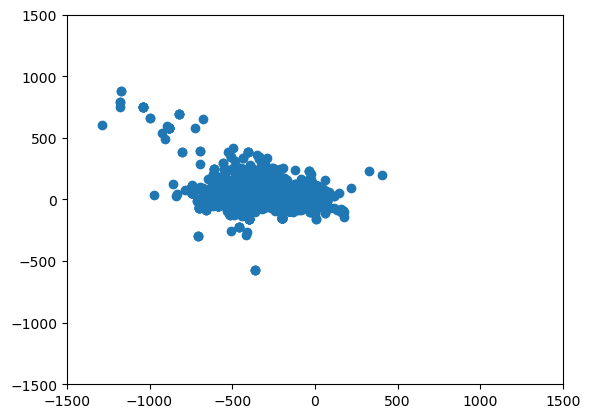

In [9]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/rchange'
completex = []
completey = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    xvals = [None]*len(row3)
                    yvals = [None]*len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval1 = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        xvals[i] = float(xval1)

                        try:
                            yval1 = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        yvals[i] = float(yval1)
                        
                    completex = completex + xvals
                    completey = completey + yvals
                
plt.scatter(completex,completey)
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
plt.show

#### For reference, end action is 0, lturn is 1, rturn is 2, lchange is 3, rchange is 4

In [10]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/end_action'
xval=0
yval=0
trainset = np.zeros((90,2,1))
trainsety = np.zeros((1,1,1))
testset = np.zeros((90,2,1))
testsety = np.zeros((1,1,1))
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                print(os.path.join(subdir, 'gazedata.csv'))
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    incompleteset = np.zeros((len(row3),2))
                    lengthdrive = len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        incompleteset[i,0] = float(xval)
                        try:
                            yval = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        incompleteset[i,1] = float(yval)
                        
                    if random.random() < 0.8:
                        for i in range(lengthdrive): 
                            tempset = np.zeros((90,2,1))
                            if i < 90:
                                tempset[89-i:90,:,0] = incompleteset[0:i+1,:]
                                trainset = np.concatenate((trainset,tempset), axis=2)
                            else:
                                tempset[:,:,0] = incompleteset[i-90:i,:]
                                trainset = np.concatenate((trainset,tempset), axis=2)

                            trainsety = np.concatenate((trainsety,np.zeros((1,1,1))), axis=2)
                    else:        
                        for i in range(lengthdrive): 
                            tempset = np.zeros((90,2,1))
                            if i < 90:
                                tempset[89-i:90,:,0] = incompleteset[0:i+1,:]
                                testset = np.concatenate((testset,tempset), axis=2)
                            else:
                                tempset[:,:,0] = incompleteset[i-90:i,:]
                                testset = np.concatenate((testset,tempset), axis=2)

                            testsety = np.concatenate((testsety,np.zeros((1,1,1))), axis=2)

C:/Users/ykung/Downloads/facecamera/end_action\20141019_091035_1106_1256\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_091136_63_213\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_132535_1548_1698\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_132726_1056_1206\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_132925_1049_1199\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_132925_536_686\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_133122_382_532\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_133122_706_856\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_133311_461_611\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_134100_1_151\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_140343_1491_1641\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141019_140917_1600_1

C:/Users/ykung/Downloads/facecamera/end_action\20141116_155306_267_417\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_155607_875_1025\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_155809_31_181\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_161859_999_1149\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_162000_711_861\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_162526_891_1041\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_162628_492_642\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_164112_787_937\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_164714_749_899\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141116_164815_735_885\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141123_153123_482_632\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141123_153224_354_504\gaz

C:/Users/ykung/Downloads/facecamera/end_action\20141220_153143_966_1116\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_153445_1337_1487\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_153747_672_822\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_153848_1522_1672\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_153848_555_705\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_154048_1450_1600\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_154149_752_902\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_154250_1074_1224\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_154250_527_677\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_160135_1367_1517\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_160135_770_920\gazedata.csv
C:/Users/ykung/Downloads/facecamera/end_action\20141220_160236_35

In [24]:
rootdir = 'C:/Users/ykung/Downloads/facecamera/rchange'
refy = np.zeros((1,1,1))
refy[0,0,0] = 4
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'gazedata.csv' in file:
            with open(os.path.join(subdir, 'gazedata.csv')) as file2:
                print(os.path.join(subdir, 'gazedata.csv'))
                reader = csv.reader(file2, delimiter = ',')
    
                for row3 in reader:
                    incompleteset = np.zeros((len(row3),2))
                    lengthdrive = len(row3)
                    for i in range(len(row3)):
                        val1 = row3[i]
                        try:
                            xval = re.search('\((.+?),', val1).group(1)
                        except AttributeError:
                            pass
                        incompleteset[i,0] = float(xval)
                        try:
                            yval = re.search(',(.+?)\)', val1).group(1)
                        except AttributeError:
                            pass
                        incompleteset[i,1] = float(yval)
                        
                    if random.random() < 0.8:
                        for i in range(lengthdrive): 
                            tempset = np.zeros((90,2,1))
                            if i < 90:
                                tempset[89-i:90,:,0] = incompleteset[0:i+1,:]
                                trainset = np.concatenate((trainset,tempset), axis=2)
                            else:
                                tempset[:,:,0] = incompleteset[i-90:i,:]
                                trainset = np.concatenate((trainset,tempset), axis=2)

                            trainsety = np.concatenate((trainsety,refy), axis=2)
                    else:        
                        for i in range(lengthdrive): 
                            tempset = np.zeros((90,2,1))
                            if i < 90:
                                tempset[89-i:90,:,0] = incompleteset[0:i+1,:]
                                testset = np.concatenate((testset,tempset), axis=2)
                            else:
                                tempset[:,:,0] = incompleteset[i-90:i,:]
                                testset = np.concatenate((testset,tempset), axis=2)

                            testsety = np.concatenate((testsety,refy), axis=2)

C:/Users/ykung/Downloads/facecamera/rchange\20141019_132825_265_415\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_132925_328_478\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_133122_516_666\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_133222_478_627\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_133311_232_382\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_133907_560_710\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_134805_989_1139\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_140343_1230_1348\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_140917_1374_1524\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_141117_74_224\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_141317_1080_1230\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141019_141630_739_889\gazedata.csv
C:/Users/ykung/Downloa

C:/Users/ykung/Downloads/facecamera/rchange\20141220_134935_1335_1485\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_135136_1035_1185\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_135438_658_808\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_135639_1039_1189\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_135841_966_1116\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_140946_1134_1284\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_153948_1199_1349\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_160940_1625_1775\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_161040_62_212\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_162145_894_1044\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_162850_1165_1315\gazedata.csv
C:/Users/ykung/Downloads/facecamera/rchange\20141220_163051_1049_1199\gazedata.csv
C:/Users/yk

In [29]:
np.save('C:/Users/ykung/Downloads/facecamera/trainset',trainset)

In [30]:
np.save('C:/Users/ykung/Downloads/facecamera/trainsety',trainsety)

In [31]:
np.save('C:/Users/ykung/Downloads/facecamera/testset',testset)

In [32]:
np.save('C:/Users/ykung/Downloads/facecamera/testsety',testsety)

In [25]:
print(np.shape(trainset))

(90, 2, 68736)


In [26]:
print(np.shape(trainsety))

(1, 1, 68736)


In [27]:
print(np.shape(testset))

(90, 2, 18816)


In [28]:
print(np.shape(testsety))

(1, 1, 18816)


In [83]:
var5 = np.concatenate((var5,var4),axis=2)
var5

array([[[0., 1., 1., 1.],
        [0., 1., 1., 1.]],

       [[0., 1., 1., 1.],
        [0., 1., 1., 1.]],

       [[0., 1., 1., 1.],
        [0., 1., 1., 1.]],

       [[0., 1., 1., 1.],
        [0., 1., 1., 1.]]])

In [86]:
var5[3,:,0]

array([0., 0.])

In [5]:
random.random()

0.603267297323112